In [1]:
# based on https://rlhick.people.wm.edu/posts/custom-likes-tensorflow.html

In [152]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


import tensorflow_probability as tfp
tfd = tfp.distributions

# messing around with tf.gather and tf.gather_nd

In [40]:
ra = tf.range(10)

In [41]:
ra = tf.stack((ra,ra+10))

In [42]:
ra

<tf.Tensor: shape=(2, 10), dtype=int32, numpy=
array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]], dtype=int32)>

In [43]:
ra[0,3]

<tf.Tensor: shape=(), dtype=int32, numpy=3>

In [44]:
ra[1,3]

<tf.Tensor: shape=(), dtype=int32, numpy=13>

In [31]:
tf.gather_nd(ra, [0,3])

<tf.Tensor: shape=(), dtype=int32, numpy=3>

In [50]:
tf.gather_nd(ra, [[0],[1],[0]])

<tf.Tensor: shape=(3, 10), dtype=int32, numpy=
array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
       [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9]], dtype=int32)>

In [48]:
tf.gather_nd(ra, [[0],[1]])

<tf.Tensor: shape=(2, 10), dtype=int32, numpy=
array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]], dtype=int32)>

In [65]:
tf.gather_nd(ra, [[0,2],[1,2]])

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([ 2, 12], dtype=int32)>

In [57]:
tf.gather(ra, [[0],[1]])

<tf.Tensor: shape=(2, 1, 10), dtype=int32, numpy=
array([[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9]],

       [[10, 11, 12, 13, 14, 15, 16, 17, 18, 19]]], dtype=int32)>

# tf.function

In [69]:
def mult_fun(x, y):
    return tf.matmul(x, y)

@tf.function()
def mult_tf_fun(x, y):
    return tf.matmul(x, y)

@tf.function(experimental_compile=True)
def mult_tf_xla_fun(x, y):
    return tf.matmul(x, y)

print("The function mult_fun runs slow: ", type(mult_fun))
print("The function mult_tf_fun runs fast: ", type(mult_tf_fun))
print("The function mult_tf_fun runs fastest (XLA): ", type(mult_tf_xla_fun))

The function mult_fun runs slow:  <class 'function'>
The function mult_tf_fun runs fast:  <class 'tensorflow.python.eager.def_function.Function'>
The function mult_tf_fun runs fastest (XLA):  <class 'tensorflow.python.eager.def_function.Function'>


NOTE:
The data types of your tensorflow function arguments also matter. In general python function arguments will require tensorflow to automatically rebuild compute graphs whereas tensorflow arguments will not cause a rebuild (so will run faster). If you need changes to the graph at runtime (e.g. number of samples, number of chains, etc.) then pass in the variable as a python variable as that will require a rebuild of the graph which is needed to run successfully.

# a toy problem

In [140]:
dtype = tf.float32

# true params

a_true = 1
b_true = 2
c_true = 3

N = 500
# true error std deviation
n_true = 0.2

x = np.linspace(0, 1, 500).reshape(-1, 1)

noise_x = np.random.rand(N).reshape(-1,1)


y = a_true*x + b_true*x**2 + c_true + n_true*noise_x

In [141]:
x.shape

(500, 1)

In [142]:
y.shape

(500, 1)

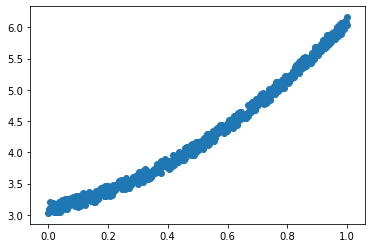

In [143]:
plt.figure()
plt.scatter(x, y)

## turn data into tf datatypes

In [147]:
X = tf.constant(x, dtype=dtype)
Y = tf.constant(y, dtype=dtype)

In [148]:
print(type(X))
print(X.dtype)
print(X.shape)
# extract the first 5 tensors into numpy array
print(X.numpy()[:5])

<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
(500, 1)
[[0.        ]
 [0.00200401]
 [0.00400802]
 [0.00601202]
 [0.00801603]]


In [149]:
pi = tf.constant(np.pi, dtype=dtype)

In [174]:
@tf.function
def norm_loglike(X, Y, a, b, c, sigma):
    
    # model
    yhat = a*X + b*X**2 + c
    
    ll = -(X.shape[0]/2) * tf.math.log(2*pi*sigma**2) - (1./(2.*sigma**2)) * tf.math.reduce_sum((Y - yhat)**2)
    
    return ll

In [175]:
norm_loglike(X, Y, a_true, b_true, c_true, n_true)

<tf.Tensor: shape=(), dtype=float32, numpy=259.22455>

In [176]:
# lets check that this agrees with the tfp.Normal log-likelihood
yhat = a_true*X + b_true*X**2 + c_true
tfp_norm = tfd.Normal(loc=yhat, scale=n_true)
tf.reduce_sum(tfp_norm.log_prob(Y))

<tf.Tensor: shape=(), dtype=float32, numpy=259.22455>

In [178]:
%%timeit
norm_loglike(X, Y, a_true, b_true, c_true, n_true)

97 µs ± 572 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [177]:
%%timeit
tf.reduce_sum(tfp_norm.log_prob(Y))

133 µs ± 3.04 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
